# Training Deep Neural Networks (Tiếp)
Trong buổi này, chúng ta tiếp tục làm quen với một số kỹ thuật huấn luyện mạng nơ-ron

In [1]:
!nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Sat Nov  1 15:25:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Cài đặt BatchNorm

In [4]:
def compare_bn(bn1, bn2):
    err = False
    if not torch.allclose(bn1.running_mean, bn2.running_mean):
        print('Diff in running_mean: {} vs {}'.format(
            bn1.running_mean, bn2.running_mean))
        err = True

    if not torch.allclose(bn1.running_var, bn2.running_var):
        print('Diff in running_var: {} vs {}'.format(
            bn1.running_var, bn2.running_var))
        err = True

    if bn1.affine and bn2.affine:
        if not torch.allclose(bn1.weight, bn2.weight):
            print('Diff in weight: {} vs {}'.format(
                bn1.weight, bn2.weight))
            err = True

        if not torch.allclose(bn1.bias, bn2.bias):
            print('Diff in bias: {} vs {}'.format(
                bn1.bias, bn2.bias))
            err = True

    if not err:
        print('All parameters are equal!')


class MyBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1,
                 affine=True, track_running_stats=True):
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            # use biased var in train
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        # Chuẩn hoá input
        ######################
        ### YOUR CODE HERE ###
        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        ######################
        if self.affine:
            # Biến đổi input sau khi chuẩn hoá
            ######################
            ### YOUR CODE HERE ###
            input = input * self.weight[None, :, None, None] + self.bias[None, :, None, None]
            ######################

        return input


# Init BatchNorm layers
my_bn = MyBatchNorm2d(3, affine=True)
bn = nn.BatchNorm2d(3, affine=True)

compare_bn(my_bn, bn)  # weight and bias should be different
# Load weight and bias
my_bn.load_state_dict(bn.state_dict())
compare_bn(my_bn, bn)

# Run train
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)
    print('Max diff: ', (out1 - out2).abs().max())

# Run eval
my_bn.eval()
bn.eval()
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)

All parameters are equal!
All parameters are equal!
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(1.4305e-06, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(7.1526e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are

### 2. Cài đặt chiến lược thay đổi tốc độ học: Warm-up + Cosine Annealing LR

In [5]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [6]:
trainset, testset = load_data('./data')
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
)

epochs = 50
warm_epoch = 5
init_lr = 1e-1
last_lr = 1e-5
T_max = epochs
T_cur = 0
lr_list = [0]

net = Net()
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=init_lr, momentum=0.9)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


In [7]:
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    T_cur += 1

    # warm-up and cosine annealing lr

    ######################
    ### YOUR CODE HERE ###
    if epoch <= warm_epoch:
        optimizer.param_groups[0]['lr'] = (1.0 * epoch) / warm_epoch  * init_lr
    else:
        # cosine annealing lr
        optimizer.param_groups[0]['lr'] = last_lr + (init_lr - last_lr) * (1 + np.cos(T_cur * np.pi / T_max)) / 2

    ######################

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i + 1 == len(trainloader):
            print("[Epoch %d] loss: %.3f" % (epoch, running_loss / epoch_steps))
            running_loss = 0.0

    lr_list.append(optimizer.param_groups[0]['lr'])

print("Finished Training")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 1] loss: 2.301
[Epoch 2] loss: 2.196
[Epoch 3] loss: 2.099
[Epoch 4] loss: 2.108
[Epoch 5] loss: 2.248
[Epoch 6] loss: 2.313
[Epoch 7] loss: 2.324
[Epoch 8] loss: 2.320
[Epoch 9] loss: 2.339
[Epoch 10] loss: 2.361
[Epoch 11] loss: 2.361
[Epoch 12] loss: 2.361
[Epoch 13] loss: 2.361
[Epoch 14] loss: 2.361
[Epoch 15] loss: 2.361
[Epoch 16] loss: 2.361
[Epoch 17] loss: 2.361
[Epoch 18] loss: 2.361
[Epoch 19] loss: 2.361
[Epoch 20] loss: 2.361
[Epoch 21] loss: 2.361
[Epoch 22] loss: 2.361
[Epoch 23] loss: 2.361
[Epoch 24] loss: 2.361
[Epoch 25] loss: 2.361
[Epoch 26] loss: 2.361
[Epoch 27] loss: 2.361
[Epoch 28] loss: 2.361
[Epoch 29] loss: 2.361
[Epoch 30] loss: 2.361
[Epoch 31] loss: 2.361
[Epoch 32] loss: 2.361
[Epoch 33] loss: 2.361
[Epoch 34] loss: 2.361
[Epoch 35] loss: 2.361
[Epoch 36] loss: 2.361
[Epoch 37] loss: 2.361
[Epoch 38] loss: 2.361
[Epoch 39] loss: 2.361
[Epoch 40] loss: 2.361
[Epoch 41] loss: 2.361
[Epoch 42] loss: 2.361
[Epoch 43] loss: 2.361
[Epoch 44] loss: 2.3

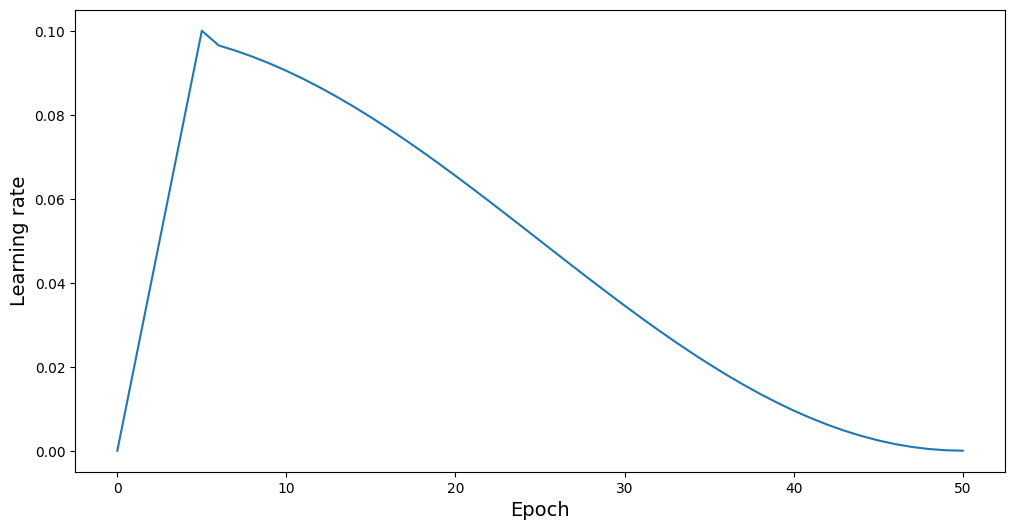

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(lr_list))), lr_list, label="lr")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Learning rate", fontsize=14)
plt.show()

### 3. Tuning siêu tham số

Cài đặt thư viện ray

In [9]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [10]:
import os
from ray.tune import CLIReporter
from ray import tune
from torch.utils.data import random_split
from functools import partial

Viết hàm huấn luyện mô hình nơ-ron trên tập CIFAR10

In [11]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            print("*"*10, path, "*"*10)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

Lựa chọn siêu tham số tốt (hyperparameter tuning): l1 nhận giá trị 32 hoặc 64, l2 nhận giá trị 32 hoặc 64, lr bằng 1e-4 hoặc 1e-2, batchsize cố định 16

In [12]:
def main(num_samples=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")

    # Liệt kê các giá trị của các siêu tham số cần tìm kiếm
    ######################
    ### YOUR CODE HERE ###
    config = {
        "l1": tune.grid_search([32, 64]),
        "l2": tune.grid_search([16, 32]),
        "lr": tune.grid_search([1e-4, 1e-2]),
        "batch_size": tune.grid_search([16])
    }
    ######################

    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        progress_reporter=reporter)

main(num_samples=10, gpus_per_trial=1)

2025-11-01 15:40:27,644	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2025-11-01 15:40:36,419	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-11-01 15:40:36,465	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-11-01 15:40:36,469	WARNING callback.py:143 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2025-11-01 15:40:36,473	WARNING tune.py:9

+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-11-01_15-40-36   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 80                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-11-01_15-40-36

Trial status: 80 PENDING
Current time: 2025-11-01 15:40:37. Total running time: 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00000   PEND

(func pid=4297) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=4297)   warnings.warn(
(func pid=4297) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=4297)   return self._call_impl(*args, **kwargs)
(pid=gcs_server) [2025-11-01 15:40:53,725 E 3991 3991] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of r

(func pid=4297) [1,  2000] loss: 2.303

Trial status: 1 RUNNING | 79 PENDING
Current time: 2025-11-01 15:41:07. Total running time: 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00000   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00001   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00002   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00003   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00004   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00005   PENDING      64     16   0.01               16 |
+--------------------------------------------------------------------------+
74 more PENDING


2025-11-01 15:41:09,315	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00000 errored after 0 iterations at 2025-11-01 15:41:09. Total running time: 32s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00000_0_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00001 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00001 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=4603) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=4603)   warnings.warn(
(func pid=4603) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=4603)   return self._call_impl(*args, **kwargs)


(func pid=4603) [1,  2000] loss: 2.303

Trial status: 1 ERROR | 1 RUNNING | 78 PENDING
Current time: 2025-11-01 15:41:37. Total running time: 1min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00001   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00002   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00003   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00004   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00005   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00006   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
+--

2025-11-01 15:41:44,796	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00001 errored after 0 iterations at 2025-11-01 15:41:44. Total running time: 1min 8s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00001_1_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00002 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00002 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=4893) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=4893)   warnings.warn(
(func pid=4893) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=4893)   return self._call_impl(*args, **kwargs)



Trial status: 2 ERROR | 1 RUNNING | 77 PENDING
Current time: 2025-11-01 15:42:07. Total running time: 1min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00002   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00003   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00004   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00005   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00006   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00007   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        

2025-11-01 15:42:18,993	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00002 errored after 0 iterations at 2025-11-01 15:42:19. Total running time: 1min 42s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00002_2_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00003 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00003 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=5189) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=5189)   warnings.warn(
(func pid=5189) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=5189)   return self._call_impl(*args, **kwargs)



Trial status: 3 ERROR | 1 RUNNING | 76 PENDING
Current time: 2025-11-01 15:42:37. Total running time: 2min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00003   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00004   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00005   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00006   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00007   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00008   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        6

2025-11-01 15:42:53,811	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00003 errored after 0 iterations at 2025-11-01 15:42:53. Total running time: 2min 17s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00003_3_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00004 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00004 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=5476) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=5476)   warnings.warn(
(func pid=5476) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=5476)   return self._call_impl(*args, **kwargs)



Trial status: 4 ERROR | 1 RUNNING | 75 PENDING
Current time: 2025-11-01 15:43:07. Total running time: 2min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00004   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00005   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00006   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00007   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00008   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00009   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        

2025-11-01 15:43:28,495	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00004
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00004 errored after 0 iterations at 2025-11-01 15:43:28. Total running time: 2min 52s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00004_4_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial status: 5 ERROR | 75 PENDING
Current time: 2025-11-01 15:43:37. Total running time: 3min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00005   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00006   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00007   PENDING      64     32   0.01               16 |
| train_cifar_1c521_

(func pid=5765) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=5765)   warnings.warn(
(func pid=5765) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=5765)   return self._call_impl(*args, **kwargs)


(func pid=5765) [1,  2000] loss: 2.288


2025-11-01 15:44:01,965	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00005
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00005 errored after 0 iterations at 2025-11-01 15:44:01. Total running time: 3min 25s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00005_5_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial status: 6 ERROR | 74 PENDING
Current time: 2025-11-01 15:44:07. Total running time: 3min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00006   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00007   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00008   PENDING      32     16   0.0001             16 |
| train_cifar_1c521

(func pid=6055) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=6055)   warnings.warn(
(func pid=6055) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=6055)   return self._call_impl(*args, **kwargs)


(func pid=6055) [1,  2000] loss: 2.274


2025-11-01 15:44:37,349	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00006
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00006 errored after 0 iterations at 2025-11-01 15:44:37. Total running time: 4min 0s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00006_6_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial status: 7 ERROR | 73 PENDING
Current time: 2025-11-01 15:44:37. Total running time: 4min 1s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00007   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00008   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00009   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00010

(func pid=6344) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=6344)   warnings.warn(
(func pid=6344) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=6344)   return self._call_impl(*args, **kwargs)


(func pid=6344) [1,  2000] loss: 2.269

Trial status: 7 ERROR | 1 RUNNING | 72 PENDING
Current time: 2025-11-01 15:45:07. Total running time: 4min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00007   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00008   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00009   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00010   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00011   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00012   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| 

2025-11-01 15:45:10,919	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00007 errored after 0 iterations at 2025-11-01 15:45:10. Total running time: 4min 34s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00007_7_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00008 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00008 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=6632) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=6632)   warnings.warn(
(func pid=6632) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=6632)   return self._call_impl(*args, **kwargs)



Trial status: 8 ERROR | 1 RUNNING | 71 PENDING
Current time: 2025-11-01 15:45:38. Total running time: 5min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00008   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00009   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00010   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00011   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00012   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00013   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        6

2025-11-01 15:45:46,342	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00008
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00008 errored after 0 iterations at 2025-11-01 15:45:46. Total running time: 5min 9s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00008_8_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00009 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00009 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=6926) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=6926)   warnings.warn(
(func pid=6926) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=6926)   return self._call_impl(*args, **kwargs)



Trial status: 9 ERROR | 1 RUNNING | 70 PENDING
Current time: 2025-11-01 15:46:08. Total running time: 5min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00009   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00010   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00011   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00012   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00013   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00014   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        

2025-11-01 15:46:18,789	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00009
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00009 errored after 0 iterations at 2025-11-01 15:46:18. Total running time: 5min 42s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00009_9_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00010 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00010 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=7210) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=7210)   warnings.warn(
(func pid=7210) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=7210)   return self._call_impl(*args, **kwargs)



Trial status: 10 ERROR | 1 RUNNING | 69 PENDING
Current time: 2025-11-01 15:46:38. Total running time: 6min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00010   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00011   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00012   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00013   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00014   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00015   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        

2025-11-01 15:46:55,119	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00010
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00010 errored after 0 iterations at 2025-11-01 15:46:55. Total running time: 6min 18s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00010_10_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial status: 11 ERROR | 69 PENDING
Current time: 2025-11-01 15:47:08. Total running time: 6min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00011   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00012   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00013   PENDING      64     16   0.01               16 |
| train_cifar_1c5

(func pid=7522) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=7522)   warnings.warn(
(func pid=7522) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=7522)   return self._call_impl(*args, **kwargs)


(func pid=7522) [1,  2000] loss: 2.303


2025-11-01 15:47:32,908	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00011
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00011 errored after 0 iterations at 2025-11-01 15:47:32. Total running time: 6min 56s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00011_11_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial status: 12 ERROR | 68 PENDING
Current time: 2025-11-01 15:47:38. Total running time: 7min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00012   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00013   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00014   PENDING      32     32   0.01               16 |
| train_cifar_1c52

(func pid=7805) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=7805)   warnings.warn(
(func pid=7805) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=7805)   return self._call_impl(*args, **kwargs)


(func pid=7805) [1,  2000] loss: 2.276


2025-11-01 15:48:07,782	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00012
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00012 errored after 0 iterations at 2025-11-01 15:48:07. Total running time: 7min 31s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00012_12_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial status: 13 ERROR | 67 PENDING
Current time: 2025-11-01 15:48:08. Total running time: 7min 31s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00013   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00014   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00015   PENDING      64     32   0.01               16 |
| train_cifar_1c521_0

(func pid=8088) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=8088)   warnings.warn(
(func pid=8088) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=8088)   return self._call_impl(*args, **kwargs)


(func pid=8088) [1,  2000] loss: 2.269

Trial status: 13 ERROR | 1 RUNNING | 66 PENDING
Current time: 2025-11-01 15:48:38. Total running time: 8min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00013   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00014   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00015   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00016   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00017   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00018   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| 

2025-11-01 15:48:42,747	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00013
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00013 errored after 0 iterations at 2025-11-01 15:48:42. Total running time: 8min 6s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00013_13_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00014 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00014 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=8378) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=8378)   warnings.warn(
(func pid=8378) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=8378)   return self._call_impl(*args, **kwargs)



Trial status: 14 ERROR | 1 RUNNING | 65 PENDING
Current time: 2025-11-01 15:49:08. Total running time: 8min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00014   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00015   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00016   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00017   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00018   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00019   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 15:49:16,191	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00014
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00014 errored after 0 iterations at 2025-11-01 15:49:16. Total running time: 8min 39s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00014_14_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00015 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00015 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=8660) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=8660)   warnings.warn(
(func pid=8660) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=8660)   return self._call_impl(*args, **kwargs)



Trial status: 15 ERROR | 1 RUNNING | 64 PENDING
Current time: 2025-11-01 15:49:38. Total running time: 9min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00015   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00016   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00017   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00018   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00019   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00020   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        

2025-11-01 15:49:51,516	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00015
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00015 errored after 0 iterations at 2025-11-01 15:49:51. Total running time: 9min 15s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00015_15_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00016 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00016 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=8942) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=8942)   warnings.warn(
(func pid=8942) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=8942)   return self._call_impl(*args, **kwargs)



Trial status: 16 ERROR | 1 RUNNING | 63 PENDING
Current time: 2025-11-01 15:50:08. Total running time: 9min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00016   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00017   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00018   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00019   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00020   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00021   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 15:50:24,932	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00016
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00016 errored after 0 iterations at 2025-11-01 15:50:24. Total running time: 9min 48s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00016_16_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00017 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00017 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=9232) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=9232)   warnings.warn(
(func pid=9232) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=9232)   return self._call_impl(*args, **kwargs)



Trial status: 17 ERROR | 1 RUNNING | 62 PENDING
Current time: 2025-11-01 15:50:38. Total running time: 10min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00017   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00018   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00019   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00020   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00021   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00022   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 15:51:00,438	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00017
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00017 errored after 0 iterations at 2025-11-01 15:51:00. Total running time: 10min 23s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00017_17_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial status: 18 ERROR | 62 PENDING
Current time: 2025-11-01 15:51:08. Total running time: 10min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00018   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00019   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00020   PENDING      32     16   0.01               16 |
| train_cifar_1

(func pid=9516) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=9516)   warnings.warn(
(func pid=9516) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=9516)   return self._call_impl(*args, **kwargs)


(func pid=9516) [1,  2000] loss: 2.303


2025-11-01 15:51:33,934	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00018
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00018 errored after 0 iterations at 2025-11-01 15:51:33. Total running time: 10min 57s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00018_18_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial status: 19 ERROR | 61 PENDING
Current time: 2025-11-01 15:51:38. Total running time: 11min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00019   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00020   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00021   PENDING      64     16   0.01               16 |
| train_cifar_1c

(func pid=9801) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=9801)   warnings.warn(
(func pid=9801) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=9801)   return self._call_impl(*args, **kwargs)


(func pid=9801) [1,  2000] loss: 2.303

Trial status: 19 ERROR | 1 RUNNING | 60 PENDING
Current time: 2025-11-01 15:52:08. Total running time: 11min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00019   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00020   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00021   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00022   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00023   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00024   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 15:52:09,197	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00019
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00019 errored after 0 iterations at 2025-11-01 15:52:09. Total running time: 11min 32s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00019_19_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00020 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00020 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=10084) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=10084)   warnings.warn(
(func pid=10084) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=10084)   return self._call_impl(*args, **kwargs)


(func pid=10084) [1,  2000] loss: 2.263

Trial status: 20 ERROR | 1 RUNNING | 59 PENDING
Current time: 2025-11-01 15:52:38. Total running time: 12min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00020   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00021   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00022   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00023   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00024   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00025   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 15:52:44,852	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00020
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00020 errored after 0 iterations at 2025-11-01 15:52:44. Total running time: 12min 8s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00020_20_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00021 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00021 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=10371) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=10371)   warnings.warn(
(func pid=10371) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=10371)   return self._call_impl(*args, **kwargs)



Trial status: 21 ERROR | 1 RUNNING | 58 PENDING
Current time: 2025-11-01 15:53:08. Total running time: 12min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00021   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00022   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00023   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00024   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00025   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00026   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 15:53:18,261	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00021
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00021 errored after 0 iterations at 2025-11-01 15:53:18. Total running time: 12min 41s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00021_21_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00022 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00022 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=10654) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=10654)   warnings.warn(
(func pid=10654) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=10654)   return self._call_impl(*args, **kwargs)



Trial status: 22 ERROR | 1 RUNNING | 57 PENDING
Current time: 2025-11-01 15:53:38. Total running time: 13min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00022   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00023   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00024   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00025   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00026   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00027   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 15:53:53,881	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00022
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00022 errored after 0 iterations at 2025-11-01 15:53:53. Total running time: 13min 17s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00022_22_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00023 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00023 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=10937) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=10937)   warnings.warn(
(func pid=10937) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=10937)   return self._call_impl(*args, **kwargs)



Trial status: 23 ERROR | 1 RUNNING | 56 PENDING
Current time: 2025-11-01 15:54:08. Total running time: 13min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00023   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00024   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00025   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00026   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00027   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00028   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 15:54:26,990	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00023
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00023 errored after 0 iterations at 2025-11-01 15:54:26. Total running time: 13min 50s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00023_23_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00024 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00024 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+

Trial status: 24 ERROR | 1 RUNNING | 55 PENDING
Current time: 2025-11-01 15:54:38. Total running time: 14min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_

(func pid=11215) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=11215)   warnings.warn(
(func pid=11215) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=11215)   return self._call_impl(*args, **kwargs)


(func pid=11215) [1,  2000] loss: 2.303


2025-11-01 15:55:01,820	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00024
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00024 errored after 0 iterations at 2025-11-01 15:55:01. Total running time: 14min 25s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00024_24_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial status: 25 ERROR | 55 PENDING
Current time: 2025-11-01 15:55:08. Total running time: 14min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00025   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00026   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00027   PENDING      64     32   0.0001             16 |
| train_cifar_1

(func pid=11503) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=11503)   warnings.warn(
(func pid=11503) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=11503)   return self._call_impl(*args, **kwargs)


(func pid=11503) [1,  2000] loss: 2.303


2025-11-01 15:55:35,214	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00025
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00025 errored after 0 iterations at 2025-11-01 15:55:35. Total running time: 14min 58s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00025_25_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial status: 26 ERROR | 54 PENDING
Current time: 2025-11-01 15:55:39. Total running time: 15min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00026   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00027   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00028   PENDING      32     16   0.01               16 |
| train_cifar_1c

(func pid=11784) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=11784)   warnings.warn(
(func pid=11784) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=11784)   return self._call_impl(*args, **kwargs)


(func pid=11784) [1,  2000] loss: 2.303

Trial status: 26 ERROR | 1 RUNNING | 53 PENDING
Current time: 2025-11-01 15:56:09. Total running time: 15min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00026   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00027   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00028   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00029   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00030   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00031   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

2025-11-01 15:56:11,513	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00026
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00026 errored after 0 iterations at 2025-11-01 15:56:11. Total running time: 15min 35s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00026_26_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00027 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00027 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=12075) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=12075)   warnings.warn(
(func pid=12075) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=12075)   return self._call_impl(*args, **kwargs)


(func pid=12075) [1,  2000] loss: 2.303

Trial status: 27 ERROR | 1 RUNNING | 52 PENDING
Current time: 2025-11-01 15:56:39. Total running time: 16min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00027   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00028   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00029   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00030   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00031   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00032   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 15:56:45,824	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00027
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00027 errored after 0 iterations at 2025-11-01 15:56:45. Total running time: 16min 9s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00027_27_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00028 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00028 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=12357) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=12357)   warnings.warn(
(func pid=12357) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=12357)   return self._call_impl(*args, **kwargs)



Trial status: 28 ERROR | 1 RUNNING | 51 PENDING
Current time: 2025-11-01 15:57:09. Total running time: 16min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00028   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00029   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00030   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00031   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00032   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00033   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 15:57:20,924	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00028
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00028 errored after 0 iterations at 2025-11-01 15:57:20. Total running time: 16min 44s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00028_28_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00029 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00029 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=12639) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=12639)   warnings.warn(
(func pid=12639) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=12639)   return self._call_impl(*args, **kwargs)



Trial status: 29 ERROR | 1 RUNNING | 50 PENDING
Current time: 2025-11-01 15:57:39. Total running time: 17min 2s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00029   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00030   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00031   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00032   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00033   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00034   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 15:57:56,491	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00029
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00029 errored after 0 iterations at 2025-11-01 15:57:56. Total running time: 17min 20s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00029_29_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-36/error.txt

Trial train_cifar_1c521_00030 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00030 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=12929) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=12929)   warnings.warn(
(func pid=12929) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=12929)   return self._call_impl(*args, **kwargs)



Trial status: 30 ERROR | 1 RUNNING | 49 PENDING
Current time: 2025-11-01 15:58:09. Total running time: 17min 32s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00030   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00031   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00032   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00033   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00034   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00035   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 15:58:30,377	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00030
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00030 errored after 0 iterations at 2025-11-01 15:58:30. Total running time: 17min 53s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00030_30_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 31 ERROR | 49 PENDING
Current time: 2025-11-01 15:58:39. Total running time: 18min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00031   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00032   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00033   PENDING      64     16   0.0001             16 |
| train_cifar_1c

(func pid=13216) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=13216)   warnings.warn(
(func pid=13216) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=13216)   return self._call_impl(*args, **kwargs)


(func pid=13216) [1,  2000] loss: 2.286


2025-11-01 15:59:06,914	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00031
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00031 errored after 0 iterations at 2025-11-01 15:59:06. Total running time: 18min 30s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00031_31_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 32 ERROR | 48 PENDING
Current time: 2025-11-01 15:59:09. Total running time: 18min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00032   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00033   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00034   PENDING      32     32   0.0001             16 |
| train_cifar_1

(func pid=13510) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=13510)   warnings.warn(
(func pid=13510) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=13510)   return self._call_impl(*args, **kwargs)


(func pid=13510) [1,  2000] loss: 2.303

Trial status: 32 ERROR | 1 RUNNING | 47 PENDING
Current time: 2025-11-01 15:59:39. Total running time: 19min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00032   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00033   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00034   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00035   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00036   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00037   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 15:59:41,961	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00032
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00032 errored after 0 iterations at 2025-11-01 15:59:41. Total running time: 19min 5s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00032_32_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00033 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00033 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=13803) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=13803)   warnings.warn(
(func pid=13803) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=13803)   return self._call_impl(*args, **kwargs)


(func pid=13803) [1,  2000] loss: 2.303

Trial status: 33 ERROR | 1 RUNNING | 46 PENDING
Current time: 2025-11-01 16:00:09. Total running time: 19min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00033   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00034   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00035   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00036   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00037   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00038   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

2025-11-01 16:00:16,913	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00033
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00033 errored after 0 iterations at 2025-11-01 16:00:16. Total running time: 19min 40s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00033_33_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00034 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00034 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=14097) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=14097)   warnings.warn(
(func pid=14097) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=14097)   return self._call_impl(*args, **kwargs)



Trial status: 34 ERROR | 1 RUNNING | 45 PENDING
Current time: 2025-11-01 16:00:39. Total running time: 20min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00034   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00035   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00036   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00037   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00038   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00039   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:00:53,626	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00034
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00034 errored after 0 iterations at 2025-11-01 16:00:53. Total running time: 20min 17s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00034_34_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00035 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00035 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=14394) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=14394)   warnings.warn(
(func pid=14394) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=14394)   return self._call_impl(*args, **kwargs)



Trial status: 35 ERROR | 1 RUNNING | 44 PENDING
Current time: 2025-11-01 16:01:09. Total running time: 20min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00035   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00036   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00037   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00038   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00039   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00040   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 16:01:29,015	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00035
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00035 errored after 0 iterations at 2025-11-01 16:01:29. Total running time: 20min 52s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00035_35_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00036 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00036 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+

Trial status: 36 ERROR | 1 RUNNING | 43 PENDING
Current time: 2025-11-01 16:01:39. Total running time: 21min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------

(func pid=14691) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=14691)   warnings.warn(
(func pid=14691) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=14691)   return self._call_impl(*args, **kwargs)


(func pid=14691) [1,  2000] loss: 2.265


2025-11-01 16:02:05,336	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00036
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00036 errored after 0 iterations at 2025-11-01 16:02:05. Total running time: 21min 28s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00036_36_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 37 ERROR | 43 PENDING
Current time: 2025-11-01 16:02:09. Total running time: 21min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00037   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00038   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00039   PENDING      64     32   0.01               16 |
| train_cifar_1

(func pid=14984) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=14984)   warnings.warn(
(func pid=14984) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=14984)   return self._call_impl(*args, **kwargs)


(func pid=14984) [1,  2000] loss: 2.245

Trial status: 37 ERROR | 1 RUNNING | 42 PENDING
Current time: 2025-11-01 16:02:39. Total running time: 22min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00037   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00038   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00039   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00040   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00041   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00042   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


(func pid=14984) [2025-11-01 16:02:41,263 E 14984 15022] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:02:41,672	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00037
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00037 errored after 0 iterations at 2025-11-01 16:02:41. Total running time: 22min 5s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00037_37_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00038 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00038 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=15289) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=15289)   warnings.warn(
(func pid=15289) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=15289)   return self._call_impl(*args, **kwargs)


(func pid=15289) [1,  2000] loss: 2.295

Trial status: 38 ERROR | 1 RUNNING | 41 PENDING
Current time: 2025-11-01 16:03:10. Total running time: 22min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00038   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00039   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00040   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00041   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00042   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00043   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

2025-11-01 16:03:17,448	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00038
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00038 errored after 0 iterations at 2025-11-01 16:03:17. Total running time: 22min 40s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00038_38_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00039 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00039 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=15582) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=15582)   warnings.warn(
(func pid=15582) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=15582)   return self._call_impl(*args, **kwargs)



Trial status: 39 ERROR | 1 RUNNING | 40 PENDING
Current time: 2025-11-01 16:03:40. Total running time: 23min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00039   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00040   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00041   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00042   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00043   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00044   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:03:54,093	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00039
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00039 errored after 0 iterations at 2025-11-01 16:03:54. Total running time: 23min 17s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00039_39_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00040 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00040 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=15881) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=15881)   warnings.warn(
(func pid=15881) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=15881)   return self._call_impl(*args, **kwargs)



Trial status: 40 ERROR | 1 RUNNING | 39 PENDING
Current time: 2025-11-01 16:04:10. Total running time: 23min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00040   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00041   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00042   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00043   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00044   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00045   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

(func pid=15881) [2025-11-01 16:04:30,502 E 15881 15922] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:04:31,522	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00040
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00040 errored after 0 iterations at 2025-11-01 16:04:31. Total running time: 23min 55s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00040_40_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 41 ERROR | 39 PENDING
Current time: 2025-11-01 16:04:40. Total running time: 24min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00041   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00042   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00043   PENDING      64     32   0.0001             16 |
| train_cifar_1c

(func pid=16182) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=16182)   warnings.warn(
(func pid=16182) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=16182)   return self._call_impl(*args, **kwargs)


(func pid=16182) [1,  2000] loss: 2.303


2025-11-01 16:05:06,467	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00041
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00041 errored after 0 iterations at 2025-11-01 16:05:06. Total running time: 24min 29s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00041_41_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 42 ERROR | 38 PENDING
Current time: 2025-11-01 16:05:10. Total running time: 24min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00042   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00043   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00044   PENDING      32     16   0.01               16 |
| train_cifar_1

(func pid=16478) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=16478)   warnings.warn(
(func pid=16478) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=16478)   return self._call_impl(*args, **kwargs)


(func pid=16478) [1,  2000] loss: 2.303

Trial status: 42 ERROR | 1 RUNNING | 37 PENDING
Current time: 2025-11-01 16:05:40. Total running time: 25min 3s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00042   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00043   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00044   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00045   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00046   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00047   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 16:05:43,501	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00042
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00042 errored after 0 iterations at 2025-11-01 16:05:43. Total running time: 25min 7s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00042_42_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00043 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00043 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=16778) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=16778)   warnings.warn(
(func pid=16778) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=16778)   return self._call_impl(*args, **kwargs)



Trial status: 43 ERROR | 1 RUNNING | 36 PENDING
Current time: 2025-11-01 16:06:10. Total running time: 25min 33s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00043   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00044   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00045   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00046   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00047   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00048   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

(func pid=16778) [2025-11-01 16:06:20,959 E 16778 16823] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:06:21,756	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00043
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00043 errored after 0 iterations at 2025-11-01 16:06:21. Total running time: 25min 45s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00043_43_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00044 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00044 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=17086) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=17086)   warnings.warn(
(func pid=17086) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=17086)   return self._call_impl(*args, **kwargs)



Trial status: 44 ERROR | 1 RUNNING | 35 PENDING
Current time: 2025-11-01 16:06:40. Total running time: 26min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00044   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00045   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00046   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00047   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00048   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00049   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

(func pid=17086) [2025-11-01 16:06:58,433 E 17086 17124] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:06:59,485	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00044
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00044 errored after 0 iterations at 2025-11-01 16:06:59. Total running time: 26min 23s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00044_44_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00045 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00045 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+

Trial status: 45 ERROR | 1 RUNNING | 34 PENDING
Current time: 2025-11-01 16:07:10. Total running time: 26min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----

(func pid=17388) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=17388)   warnings.warn(
(func pid=17388) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=17388)   return self._call_impl(*args, **kwargs)


(func pid=17388) [1,  2000] loss: 2.270


2025-11-01 16:07:35,607	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00045
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00045 errored after 0 iterations at 2025-11-01 16:07:35. Total running time: 26min 59s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00045_45_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 46 ERROR | 34 PENDING
Current time: 2025-11-01 16:07:40. Total running time: 27min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00046   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00047   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00048   PENDING      32     16   0.0001             16 |
| train_cifar_1c

(func pid=17688) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=17688)   warnings.warn(
(func pid=17688) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=17688)   return self._call_impl(*args, **kwargs)


(func pid=17688) [1,  2000] loss: 2.286

Trial status: 46 ERROR | 1 RUNNING | 33 PENDING
Current time: 2025-11-01 16:08:10. Total running time: 27min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00046   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00047   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00048   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00049   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00050   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00051   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

2025-11-01 16:08:12,182	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00046
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00046 errored after 0 iterations at 2025-11-01 16:08:12. Total running time: 27min 35s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00046_46_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00047 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00047 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=17980) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=17980)   warnings.warn(
(func pid=17980) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=17980)   return self._call_impl(*args, **kwargs)


(func pid=17980) [1,  2000] loss: 2.255

Trial status: 47 ERROR | 1 RUNNING | 32 PENDING
Current time: 2025-11-01 16:08:40. Total running time: 28min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00047   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00048   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00049   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00050   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00051   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00052   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 16:08:47,116	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00047
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00047 errored after 0 iterations at 2025-11-01 16:08:47. Total running time: 28min 10s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00047_47_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00048 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00048 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=18278) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18278)   warnings.warn(
(func pid=18278) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=18278)   return self._call_impl(*args, **kwargs)



Trial status: 48 ERROR | 1 RUNNING | 31 PENDING
Current time: 2025-11-01 16:09:10. Total running time: 28min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00048   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00049   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00050   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00051   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00052   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00053   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 16:09:23,362	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00048
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00048 errored after 0 iterations at 2025-11-01 16:09:23. Total running time: 28min 46s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00048_48_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00049 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00049 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=18576) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18576)   warnings.warn(
(func pid=18576) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=18576)   return self._call_impl(*args, **kwargs)



Trial status: 49 ERROR | 1 RUNNING | 30 PENDING
Current time: 2025-11-01 16:09:40. Total running time: 29min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00049   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00050   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00051   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00052   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00053   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00054   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:10:00,645	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00049
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00049 errored after 0 iterations at 2025-11-01 16:10:00. Total running time: 29min 24s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00049_49_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00050 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00050 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+

Trial status: 50 ERROR | 1 RUNNING | 29 PENDING
Current time: 2025-11-01 16:10:10. Total running time: 29min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator

(func pid=18872) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18872)   warnings.warn(
(func pid=18872) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=18872)   return self._call_impl(*args, **kwargs)


(func pid=18872) [1,  2000] loss: 2.303


2025-11-01 16:10:35,167	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00050
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00050 errored after 0 iterations at 2025-11-01 16:10:35. Total running time: 29min 58s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00050_50_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 51 ERROR | 29 PENDING
Current time: 2025-11-01 16:10:41. Total running time: 30min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00051   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00052   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00053   PENDING      64     16   0.01               16 |
| train_cifar_1c

(func pid=19170) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=19170)   warnings.warn(
(func pid=19170) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=19170)   return self._call_impl(*args, **kwargs)


(func pid=19170) [1,  2000] loss: 2.303

Trial status: 51 ERROR | 1 RUNNING | 28 PENDING
Current time: 2025-11-01 16:11:11. Total running time: 30min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00051   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00052   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00053   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00054   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00055   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00056   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

2025-11-01 16:11:11,582	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00051
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00051 errored after 0 iterations at 2025-11-01 16:11:11. Total running time: 30min 35s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00051_51_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00052 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00052 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=19458) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=19458)   warnings.warn(
(func pid=19458) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=19458)   return self._call_impl(*args, **kwargs)


(func pid=19458) [1,  2000] loss: 2.272

Trial status: 52 ERROR | 1 RUNNING | 27 PENDING
Current time: 2025-11-01 16:11:41. Total running time: 31min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00052   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00053   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00054   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00055   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00056   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00057   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 16:11:47,925	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00052
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00052 errored after 0 iterations at 2025-11-01 16:11:47. Total running time: 31min 11s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00052_52_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00053 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00053 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=19760) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=19760)   warnings.warn(
(func pid=19760) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=19760)   return self._call_impl(*args, **kwargs)



Trial status: 53 ERROR | 1 RUNNING | 26 PENDING
Current time: 2025-11-01 16:12:11. Total running time: 31min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00053   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00054   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00055   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00056   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00057   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00058   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 16:12:23,207	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00053
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00053 errored after 0 iterations at 2025-11-01 16:12:23. Total running time: 31min 46s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00053_53_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00054 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00054 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=20060) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=20060)   warnings.warn(
(func pid=20060) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=20060)   return self._call_impl(*args, **kwargs)



Trial status: 54 ERROR | 1 RUNNING | 25 PENDING
Current time: 2025-11-01 16:12:41. Total running time: 32min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00054   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00055   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00056   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00057   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00058   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00059   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:13:00,193	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00054
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00054 errored after 0 iterations at 2025-11-01 16:13:00. Total running time: 32min 23s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00054_54_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00055 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00055 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+

Trial status: 55 ERROR | 1 RUNNING | 24 PENDING
Current time: 2025-11-01 16:13:11. Total running time: 32min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----

(func pid=20356) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=20356)   warnings.warn(
(func pid=20356) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=20356)   return self._call_impl(*args, **kwargs)


(func pid=20356) [1,  2000] loss: 2.259


(func pid=20356) [2025-11-01 16:13:36,499 E 20356 20394] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:13:37,284	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00055
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00055 errored after 0 iterations at 2025-11-01 16:13:37. Total running time: 33min 0s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00055_55_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 56 ERROR | 24 PENDING
Current time: 2025-11-01 16:13:41. Total running time: 33min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00056   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00057   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00058   PENDING      32     32   0.0001             16 |
| train_cifar_1c5

(func pid=20653) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=20653)   warnings.warn(
(func pid=20653) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=20653)   return self._call_impl(*args, **kwargs)


(func pid=20653) [1,  2000] loss: 2.303

Trial status: 56 ERROR | 1 RUNNING | 23 PENDING
Current time: 2025-11-01 16:14:11. Total running time: 33min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00056   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00057   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00058   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00059   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00060   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00061   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

2025-11-01 16:14:12,074	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00056
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00056 errored after 0 iterations at 2025-11-01 16:14:12. Total running time: 33min 35s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00056_56_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00057 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00057 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=20949) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=20949)   warnings.warn(
(func pid=20949) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=20949)   return self._call_impl(*args, **kwargs)


(func pid=20949) [1,  2000] loss: 2.303

Trial status: 57 ERROR | 1 RUNNING | 22 PENDING
Current time: 2025-11-01 16:14:41. Total running time: 34min 4s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00057   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00058   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00059   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00060   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00061   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00062   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |


2025-11-01 16:14:48,627	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00057
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00057 errored after 0 iterations at 2025-11-01 16:14:48. Total running time: 34min 12s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00057_57_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00058 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00058 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=21248) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=21248)   warnings.warn(
(func pid=21248) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=21248)   return self._call_impl(*args, **kwargs)



Trial status: 58 ERROR | 1 RUNNING | 21 PENDING
Current time: 2025-11-01 16:15:11. Total running time: 34min 34s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00058   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00059   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00060   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00061   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00062   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00063   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 16:15:24,998	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00058
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00058 errored after 0 iterations at 2025-11-01 16:15:25. Total running time: 34min 48s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00058_58_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00059 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00059 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=21549) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=21549)   warnings.warn(
(func pid=21549) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=21549)   return self._call_impl(*args, **kwargs)



Trial status: 59 ERROR | 1 RUNNING | 20 PENDING
Current time: 2025-11-01 16:15:41. Total running time: 35min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00059   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00060   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00061   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00062   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00063   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00064   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:16:00,246	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00059
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00059 errored after 0 iterations at 2025-11-01 16:16:00. Total running time: 35min 23s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00059_59_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 60 ERROR | 20 PENDING
Current time: 2025-11-01 16:16:11. Total running time: 35min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00060   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00061   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00062   PENDING      32     32   0.01               16 |
| train_cifar_1

(func pid=21840) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=21840)   warnings.warn(
(func pid=21840) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=21840)   return self._call_impl(*args, **kwargs)


(func pid=21840) [1,  2000] loss: 2.278


2025-11-01 16:16:37,940	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00060
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00060 errored after 0 iterations at 2025-11-01 16:16:37. Total running time: 36min 1s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00060_60_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 61 ERROR | 19 PENDING
Current time: 2025-11-01 16:16:41. Total running time: 36min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00061   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00062   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00063   PENDING      64     32   0.01               16 |
| train_cifar_1c5

(func pid=22141) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=22141)   warnings.warn(
(func pid=22141) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=22141)   return self._call_impl(*args, **kwargs)


(func pid=22141) [1,  2000] loss: 2.271

Trial status: 61 ERROR | 1 RUNNING | 18 PENDING
Current time: 2025-11-01 16:17:11. Total running time: 36min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00061   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00062   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00063   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00064   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00065   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00066   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |

(func pid=22141) [2025-11-01 16:17:14,254 E 22141 22183] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:17:14,689	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00061
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00061 errored after 0 iterations at 2025-11-01 16:17:14. Total running time: 36min 38s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00061_61_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00062 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00062 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=22442) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=22442)   warnings.warn(
(func pid=22442) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=22442)   return self._call_impl(*args, **kwargs)



Trial status: 62 ERROR | 1 RUNNING | 17 PENDING
Current time: 2025-11-01 16:17:41. Total running time: 37min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00062   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00063   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00064   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00065   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00066   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00067   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:17:50,012	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00062
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00062 errored after 0 iterations at 2025-11-01 16:17:50. Total running time: 37min 13s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00062_62_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00063 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00063 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=22735) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=22735)   warnings.warn(
(func pid=22735) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=22735)   return self._call_impl(*args, **kwargs)



Trial status: 63 ERROR | 1 RUNNING | 16 PENDING
Current time: 2025-11-01 16:18:11. Total running time: 37min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00063   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00064   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00065   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00066   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00067   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00068   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 16:18:27,204	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00063
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00063 errored after 0 iterations at 2025-11-01 16:18:27. Total running time: 37min 50s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00063_63_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00064 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00064 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=23039) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=23039)   warnings.warn(
(func pid=23039) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=23039)   return self._call_impl(*args, **kwargs)



Trial status: 64 ERROR | 1 RUNNING | 15 PENDING
Current time: 2025-11-01 16:18:41. Total running time: 38min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00064   RUNNING      32     16   0.0001             16 |
| train_cifar_1c521_00065   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00066   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00067   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00068   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00069   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

(func pid=23039) [2025-11-01 16:19:04,086 E 23039 23079] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:19:04,454	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00064
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00064 errored after 0 iterations at 2025-11-01 16:19:04. Total running time: 38min 27s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00064_64_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 65 ERROR | 15 PENDING
Current time: 2025-11-01 16:19:11. Total running time: 38min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00065   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00066   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00067   PENDING      64     32   0.0001             16 |
| train_cifar_1

(func pid=23336) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=23336)   warnings.warn(
(func pid=23336) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=23336)   return self._call_impl(*args, **kwargs)


(func pid=23336) [1,  2000] loss: 2.303


(func pid=23336) [2025-11-01 16:19:40,240 E 23336 23377] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14



Trial status: 65 ERROR | 1 RUNNING | 14 PENDING
Current time: 2025-11-01 16:19:41. Total running time: 39min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00065   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00066   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00067   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00068   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00069   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00070   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:19:48,511	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00065
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00065 errored after 0 iterations at 2025-11-01 16:19:48. Total running time: 39min 12s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00065_65_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00066 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00066 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=23667) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=23667)   warnings.warn(
(func pid=23667) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=23667)   return self._call_impl(*args, **kwargs)



Trial status: 66 ERROR | 1 RUNNING | 13 PENDING
Current time: 2025-11-01 16:20:11. Total running time: 39min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00066   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00067   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00068   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00069   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00070   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00071   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

(func pid=23667) [2025-11-01 16:20:24,692 E 23667 23710] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:20:29,577	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00066
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00066 errored after 0 iterations at 2025-11-01 16:20:29. Total running time: 39min 53s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00066_66_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00067 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00067 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=23988) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=23988)   warnings.warn(



Trial status: 67 ERROR | 1 RUNNING | 12 PENDING
Current time: 2025-11-01 16:20:42. Total running time: 40min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00067   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00068   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00069   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00070   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00071   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00072   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

(func pid=23988) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=23988)   return self._call_impl(*args, **kwargs)


(func pid=23988) [1,  2000] loss: 2.303


2025-11-01 16:21:04,372	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00067
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00067 errored after 0 iterations at 2025-11-01 16:21:04. Total running time: 40min 27s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00067_67_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 68 ERROR | 12 PENDING
Current time: 2025-11-01 16:21:12. Total running time: 40min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00068   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00069   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00070   PENDING      32     32   0.01               16 |
| train_cifar_1

(func pid=24287) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=24287)   warnings.warn(
(func pid=24287) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=24287)   return self._call_impl(*args, **kwargs)


(func pid=24287) [1,  2000] loss: 2.277


(func pid=24287) [2025-11-01 16:21:41,731 E 24287 24324] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14



Trial status: 68 ERROR | 1 RUNNING | 11 PENDING
Current time: 2025-11-01 16:21:42. Total running time: 41min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00068   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00069   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00070   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00071   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00072   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00073   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:21:43,282	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00068
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00068 errored after 0 iterations at 2025-11-01 16:21:43. Total running time: 41min 6s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00068_68_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00069 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00069 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=24598) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=24598)   warnings.warn(
(func pid=24598) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=24598)   return self._call_impl(*args, **kwargs)



Trial status: 69 ERROR | 1 RUNNING | 10 PENDING
Current time: 2025-11-01 16:22:12. Total running time: 41min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00069   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00070   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00071   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00072   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00073   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00074   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR      

2025-11-01 16:22:21,732	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00069
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00069 errored after 0 iterations at 2025-11-01 16:22:21. Total running time: 41min 45s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00069_69_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00070 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00070 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=24889) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=24889)   warnings.warn(
(func pid=24889) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=24889)   return self._call_impl(*args, **kwargs)



Trial status: 70 ERROR | 1 RUNNING | 9 PENDING
Current time: 2025-11-01 16:22:42. Total running time: 42min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00070   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00071   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00072   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00073   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00074   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00075   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        

2025-11-01 16:22:58,123	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00070
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00070 errored after 0 iterations at 2025-11-01 16:22:58. Total running time: 42min 21s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00070_70_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00071 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00071 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=25184) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=25184)   warnings.warn(
(func pid=25184) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=25184)   return self._call_impl(*args, **kwargs)



Trial status: 71 ERROR | 1 RUNNING | 8 PENDING
Current time: 2025-11-01 16:23:12. Total running time: 42min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00071   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00072   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00073   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00074   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00075   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00076   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:23:33,166	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00071
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00071 errored after 0 iterations at 2025-11-01 16:23:33. Total running time: 42min 56s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00071_71_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 72 ERROR | 8 PENDING
Current time: 2025-11-01 16:23:42. Total running time: 43min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00072   PENDING      32     16   0.0001             16 |
| train_cifar_1c521_00073   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00074   PENDING      32     32   0.0001             16 |
| train_cifar_1c5

(func pid=25479) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=25479)   warnings.warn(
(func pid=25479) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=25479)   return self._call_impl(*args, **kwargs)


(func pid=25479) [1,  2000] loss: 2.303


2025-11-01 16:24:09,370	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00072
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00072 errored after 0 iterations at 2025-11-01 16:24:09. Total running time: 43min 32s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00072_72_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial status: 73 ERROR | 7 PENDING
Current time: 2025-11-01 16:24:12. Total running time: 43min 35s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00073   PENDING      64     16   0.0001             16 |
| train_cifar_1c521_00074   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00075   PENDING      64     32   0.0001             16 |
| train_cifar_1c

(func pid=25772) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=25772)   warnings.warn(
(func pid=25772) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=25772)   return self._call_impl(*args, **kwargs)


(func pid=25772) [1,  2000] loss: 2.303

Trial status: 73 ERROR | 1 RUNNING | 6 PENDING
Current time: 2025-11-01 16:24:42. Total running time: 44min 5s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00073   RUNNING      64     16   0.0001             16 |
| train_cifar_1c521_00074   PENDING      32     32   0.0001             16 |
| train_cifar_1c521_00075   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00076   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00077   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00078   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
|

(func pid=25772) [2025-11-01 16:24:46,031 E 25772 25814] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:24:46,345	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00073
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00073 errored after 0 iterations at 2025-11-01 16:24:46. Total running time: 44min 9s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00073_73_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00074 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00074 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           32 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=26079) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=26079)   warnings.warn(
(func pid=26079) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=26079)   return self._call_impl(*args, **kwargs)



Trial status: 74 ERROR | 1 RUNNING | 5 PENDING
Current time: 2025-11-01 16:25:12. Total running time: 44min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00074   RUNNING      32     32   0.0001             16 |
| train_cifar_1c521_00075   PENDING      64     32   0.0001             16 |
| train_cifar_1c521_00076   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00077   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00078   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00079   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR       

2025-11-01 16:25:21,964	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00074
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00074 errored after 0 iterations at 2025-11-01 16:25:21. Total running time: 44min 45s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00074_74_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00075 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_1c521_00075 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=26375) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=26375)   warnings.warn(
(func pid=26375) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=26375)   return self._call_impl(*args, **kwargs)



Trial status: 75 ERROR | 1 RUNNING | 4 PENDING
Current time: 2025-11-01 16:25:42. Total running time: 45min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00075   RUNNING      64     32   0.0001             16 |
| train_cifar_1c521_00076   PENDING      32     16   0.01               16 |
| train_cifar_1c521_00077   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00078   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00079   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        64     16   0.0001             16 |
| train_cifar_1c521_00002   ERROR        

2025-11-01 16:25:59,099	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00075
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00075 errored after 0 iterations at 2025-11-01 16:25:59. Total running time: 45min 22s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00075_75_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00076 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00076 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         16 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=26672) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=26672)   warnings.warn(



Trial status: 76 ERROR | 1 RUNNING | 3 PENDING
Current time: 2025-11-01 16:26:12. Total running time: 45min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00076   RUNNING      32     16   0.01               16 |
| train_cifar_1c521_00077   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00078   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00079   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        64     16   0.0001             16 |
| train_cifar_1c521_00002   ERROR        32     32   0.0001             16 |
| train_cifar_1c521_00003   ERROR       

(func pid=26672) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=26672)   return self._call_impl(*args, **kwargs)


(func pid=26672) [1,  2000] loss: 2.257


2025-11-01 16:26:36,310	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00076
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00076 errored after 0 iterations at 2025-11-01 16:26:36. Total running time: 45min 59s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00076_76_batch_size=16,l1=32,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 77 ERROR | 3 PENDING
Current time: 2025-11-01 16:26:42. Total running time: 46min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00077   PENDING      64     16   0.01               16 |
| train_cifar_1c521_00078   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00079   PENDING      64     32   0.01               16 |
| train_cifar_1c5

(func pid=26980) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=26980)   warnings.warn(
(func pid=26980) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=26980)   return self._call_impl(*args, **kwargs)


(func pid=26980) [1,  2000] loss: 2.251

Trial status: 77 ERROR | 1 RUNNING | 2 PENDING
Current time: 2025-11-01 16:27:12. Total running time: 46min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00077   RUNNING      64     16   0.01               16 |
| train_cifar_1c521_00078   PENDING      32     32   0.01               16 |
| train_cifar_1c521_00079   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        64     16   0.0001             16 |
| train_cifar_1c521_00002   ERROR        32     32   0.0001             16 |
| train_cifar_1c521_00003   ERROR        64     32   0.0001             16 |


(func pid=26980) [2025-11-01 16:27:12,836 E 26980 27017] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-01 16:27:13,250	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00077
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_1c521_00077 errored after 0 iterations at 2025-11-01 16:27:13. Total running time: 46min 36s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00077_77_batch_size=16,l1=64,l2=16,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00078 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00078 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         32 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=27280) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=27280)   warnings.warn(
(func pid=27280) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=27280)   return self._call_impl(*args, **kwargs)


(func pid=27280) [1,  2000] loss: 2.276

Trial status: 78 ERROR | 1 RUNNING | 1 PENDING
Current time: 2025-11-01 16:27:42. Total running time: 47min 6s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00078   RUNNING      32     32   0.01               16 |
| train_cifar_1c521_00079   PENDING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        64     16   0.0001             16 |
| train_cifar_1c521_00002   ERROR        32     32   0.0001             16 |
| train_cifar_1c521_00003   ERROR        64     32   0.0001             16 |
| train_cifar_1c521_00004   ERROR        32     16   0.01               16 |
+

2025-11-01 16:27:49,466	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00078
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00078 errored after 0 iterations at 2025-11-01 16:27:49. Total running time: 47min 12s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00078_78_batch_size=16,l1=32,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial train_cifar_1c521_00079 started with configuration:
+-----------------------------------------------+
| Trial train_cifar_1c521_00079 config          |
+-----------------------------------------------+
| batch_size                                 16 |
| l1                                         64 |
| l2                                         32 |
| lr                                       0.01 |
+-----------------------------------------------+


(func pid=27577) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=27577)   warnings.warn(
(func pid=27577) /usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
(func pid=27577)   return self._call_impl(*args, **kwargs)



Trial status: 79 ERROR | 1 RUNNING
Current time: 2025-11-01 16:28:12. Total running time: 47min 36s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00079   RUNNING      64     32   0.01               16 |
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        64     16   0.0001             16 |
| train_cifar_1c521_00002   ERROR        32     32   0.0001             16 |
| train_cifar_1c521_00003   ERROR        64     32   0.0001             16 |
| train_cifar_1c521_00004   ERROR        32     16   0.01               16 |
+--------------------------------------------------------------------------+
74 more ERROR
(func pid=27577) [1,  2000] loss: 2.29

2025-11-01 16:28:27,026	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_1c521_00079
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 2961, in get
    values, debugger_breakpoint = worker.get_objects(
                                  ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/worker.py", line 1026, in get_objects
    raise value.as_instanceof_caus


Trial train_cifar_1c521_00079 errored after 0 iterations at 2025-11-01 16:28:27. Total running time: 47min 50s
Error file: /tmp/ray/session_2025-11-01_15-40-23_394494_187/artifacts/2025-11-01_15-40-36/train_cifar_2025-11-01_15-40-36/driver_artifacts/train_cifar_1c521_00079_79_batch_size=16,l1=64,l2=32,lr=0.0100_2025-11-01_15-40-37/error.txt

Trial status: 80 ERROR
Current time: 2025-11-01 16:28:27. Total running time: 47min 50s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_1c521_00000   ERROR        32     16   0.0001             16 |
| train_cifar_1c521_00001   ERROR        64     16   0.0001             16 |
| train_cifar_1c521_00002   ERROR        32     32   0.0001             16 |
| train_cifar_1c521_00003   

TuneError: ('Trials did not complete', [train_cifar_1c521_00000, train_cifar_1c521_00001, train_cifar_1c521_00002, train_cifar_1c521_00003, train_cifar_1c521_00004, train_cifar_1c521_00005, train_cifar_1c521_00006, train_cifar_1c521_00007, train_cifar_1c521_00008, train_cifar_1c521_00009, train_cifar_1c521_00010, train_cifar_1c521_00011, train_cifar_1c521_00012, train_cifar_1c521_00013, train_cifar_1c521_00014, train_cifar_1c521_00015, train_cifar_1c521_00016, train_cifar_1c521_00017, train_cifar_1c521_00018, train_cifar_1c521_00019, train_cifar_1c521_00020, train_cifar_1c521_00021, train_cifar_1c521_00022, train_cifar_1c521_00023, train_cifar_1c521_00024, train_cifar_1c521_00025, train_cifar_1c521_00026, train_cifar_1c521_00027, train_cifar_1c521_00028, train_cifar_1c521_00029, train_cifar_1c521_00030, train_cifar_1c521_00031, train_cifar_1c521_00032, train_cifar_1c521_00033, train_cifar_1c521_00034, train_cifar_1c521_00035, train_cifar_1c521_00036, train_cifar_1c521_00037, train_cifar_1c521_00038, train_cifar_1c521_00039, train_cifar_1c521_00040, train_cifar_1c521_00041, train_cifar_1c521_00042, train_cifar_1c521_00043, train_cifar_1c521_00044, train_cifar_1c521_00045, train_cifar_1c521_00046, train_cifar_1c521_00047, train_cifar_1c521_00048, train_cifar_1c521_00049, train_cifar_1c521_00050, train_cifar_1c521_00051, train_cifar_1c521_00052, train_cifar_1c521_00053, train_cifar_1c521_00054, train_cifar_1c521_00055, train_cifar_1c521_00056, train_cifar_1c521_00057, train_cifar_1c521_00058, train_cifar_1c521_00059, train_cifar_1c521_00060, train_cifar_1c521_00061, train_cifar_1c521_00062, train_cifar_1c521_00063, train_cifar_1c521_00064, train_cifar_1c521_00065, train_cifar_1c521_00066, train_cifar_1c521_00067, train_cifar_1c521_00068, train_cifar_1c521_00069, train_cifar_1c521_00070, train_cifar_1c521_00071, train_cifar_1c521_00072, train_cifar_1c521_00073, train_cifar_1c521_00074, train_cifar_1c521_00075, train_cifar_1c521_00076, train_cifar_1c521_00077, train_cifar_1c521_00078, train_cifar_1c521_00079])

Cài đặt thử viện skorch

In [13]:
!pip install skorch
import numpy as np
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 9.2 MB/s eta 0:00:00


Sử dụng thư viện skorch để huấn luyện

In [14]:
trainset, testset = load_data('./data')
(X, y) = np.asarray(trainset.data[:]), np.asarray(trainset.targets[:])
X = X.reshape((-1, 3, 32, 32))
X = X.astype(np.float32)
y = y.astype(np.int64)

net = NeuralNetClassifier(
    Net,
    max_epochs=5,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

# training with default config
net.fit(X, y)
y_proba = net.predict_proba(X)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3807       0.1220        2.2917  10.9420


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


      2        2.2095       0.1646        2.4066  7.6358


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


      3        2.1264       0.2393        2.0912  7.9478


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


      4        2.0535       0.2644        2.0010  6.9856


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


      5        1.9945       0.2765        1.9543  7.9418


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Dùng skorch để lựa chọn siêu tham số

In [15]:
# hyperparameter tuning
net.set_params(train_split=False, verbose=0)
# Liệt kê các giá trị siêu tham số cần search và dùng hàm gridsearchCV để tìm giá trị tối ưu

######################
### YOUR CODE HERE ###
params = {
    'lr': [1e-4, 1e-2],
    'module__l1': [32, 64],
    'module__l2': [16, 32],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)
######################

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  31.7s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  30.7s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  31.6s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  31.1s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  30.1s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  29.3s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  31.4s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  31.2s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  30.3s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=64, module__l2=32; total time=  29.9s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=64, module__l2=32; total time=  30.1s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ............lr=0.0001, module__l1=64, module__l2=32; total time=  31.5s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=32, module__l2=16; total time=  29.1s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=32, module__l2=16; total time=  29.4s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=32, module__l2=16; total time=  28.8s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=32, module__l2=32; total time=  27.9s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=32, module__l2=32; total time=  28.2s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=32, module__l2=32; total time=  29.5s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=64, module__l2=16; total time=  28.6s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=64, module__l2=16; total time=  28.3s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=64, module__l2=16; total time=  28.4s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=64, module__l2=32; total time=  28.1s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=64, module__l2=32; total time=  27.7s


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[CV] END ..............lr=0.01, module__l1=64, module__l2=32; total time=  27.7s
best score: 0.301, best params: {'lr': 0.01, 'module__l1': 64, 'module__l2': 16}
